In [ ]:
# === Instalação de dependências ===
!pip -q install ultralytics opencv-python scikit-image matplotlib ipywidgets

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

from skimage import data, exposure, filters, morphology, measure, color


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


2) Síntese de Imagens (Computação Gráfica)

Ideia da aplicação: renderizar uma esfera sintética com iluminação difusa + especular (modelo Blinn-Phong) e textura procedural em xadrez mapeada por coordenadas esféricas.
O que você demonstra: conceitos de geometria, normais, BRDF simplificada, texturização.

Texto (adicione em uma célula de texto no Colab):

Síntese ≠ processamento: aqui geramos pixels do zero a partir de um modelo matemático.

Pipeline simplificado: (1) malha/forma (esfera implícita), (2) normais, (3) luz e material, (4) cor final.

Limitações: sem sombras/som ambiente globais; é um shader bem simples, mas ilustra os fundamentos.

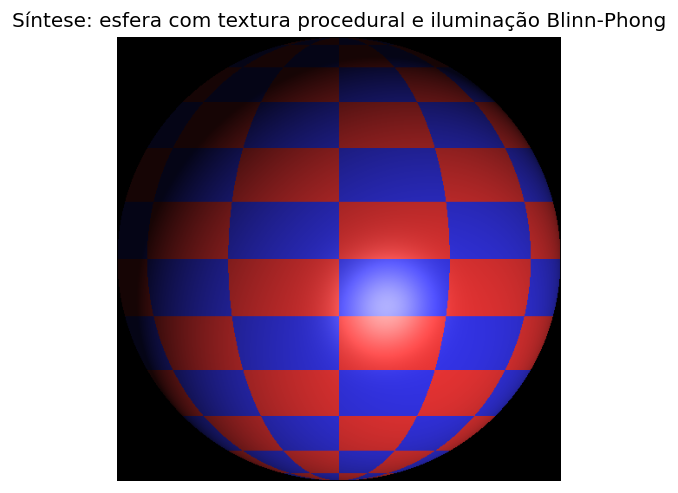

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grade de pixels
W, H = 512, 512
x, y = np.meshgrid(np.linspace(-1, 1, W), np.linspace(-1, 1, H))
r2 = x**2 + y**2
mask = r2 <= 1.0
z = np.zeros_like(x)
z[mask] = np.sqrt(1 - r2[mask])

# Normais da esfera
nx, ny, nz = x.copy(), y.copy(), z.copy()
n_norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-8
nx, ny, nz = nx/n_norm, ny/n_norm, nz/n_norm

# Luz e visão (Blinn-Phong)
L = np.array([0.5, 0.5, 1.0]); L = L/np.linalg.norm(L)
V = np.array([0, 0, 1.0])
Hvec = (L+V)/np.linalg.norm(L+V)

diffuse = np.clip(nx*L[0] + ny*L[1] + nz*L[2], 0, 1)
spec = np.clip(nx*Hvec[0] + ny*Hvec[1] + nz*Hvec[2], 0, 1)**50

# Coordenadas esféricas p/ textura xadrez
theta = np.arccos(np.clip(ny, -1, 1))  # 0..pi
phi = (np.arctan2(nz, nx) + np.pi) / (2*np.pi)  # 0..1
tiles = 12
checker = ((np.floor(theta/(np.pi/tiles)) + np.floor(phi*tiles)) % 2)

c1 = np.array([0.9, 0.2, 0.2])  # vermelho
c2 = np.array([0.2, 0.2, 0.9])  # azul
base = np.dstack([(checker==0)*c1[i] + (checker==1)*c2[i] for i in range(3)])

kd, ks, ambient = 0.9, 0.5, 0.1
img = np.clip(ambient*base + kd*base*diffuse[...,None] + ks*spec[...,None], 0, 1)

# Fundo preto
out = np.zeros_like(img)
out[mask] = img[mask]

plt.imshow(out)
plt.axis('off')
plt.title("Síntese: esfera com textura procedural e iluminação Blinn-Phong")
plt.show()


3) Processamento de Imagens

Ideia da aplicação: melhorar contraste, detectar bordas e fazer segmentação/morfologia na imagem coins() do skimage.
O que você demonstra: filtros, equalização (CLAHE), limiarização (Otsu), operações morfológicas.

Texto (adicione em uma célula de texto):

Processamento transforma imagens existentes (não gera do zero).

Mostre antes/depois e comente: quando a equalização ajuda? o que o Sobel detecta?

Diga o papel de opening para remover ruídos pequenos após o limiar.

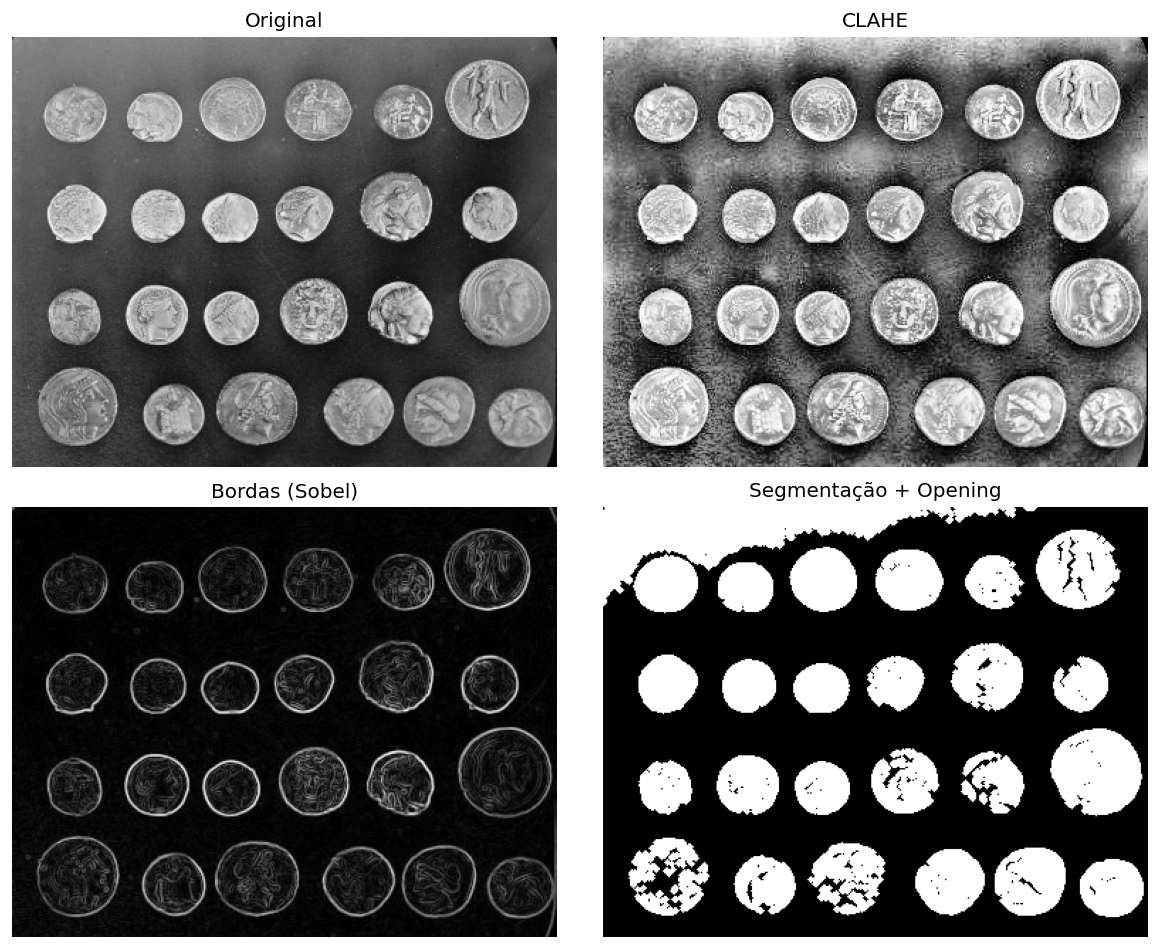

In [ ]:
from skimage import data, exposure, filters, morphology
import matplotlib.pyplot as plt

img = data.coins()  # imagem de teste (tons de cinza)

# 1) Equalização adaptativa (CLAHE)
eq = exposure.equalize_adapthist(img, clip_limit=0.03)

# 2) Detecção de bordas (Sobel)
edges = filters.sobel(img)

# 3) Segmentação por limiar (Otsu) + morfologia (opening)
th = filters.threshold_otsu(img)
binary = img > th
opened = morphology.opening(binary, morphology.disk(2))

# Visualização
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.ravel()

axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original"); axs[0].axis('off')
axs[1].imshow(eq, cmap='gray'); axs[1].set_title("CLAHE"); axs[1].axis('off')
axs[2].imshow(edges, cmap='gray'); axs[2].set_title("Bordas (Sobel)"); axs[2].axis('off')
axs[3].imshow(opened, cmap='gray'); axs[3].set_title("Segmentação + Opening"); axs[3].axis('off')

plt.tight_layout()
plt.show()


4) Visão Computacional (Artificial)

Ideia da aplicação: detecção de objetos com modelo pré-treinado YOLOv8n (Ultralytics) em uma imagem de teste.
O que você demonstra: alto nível de visão (entender o que há na imagem), transferência de aprendizado e inference.

Texto (adicione em uma célula de texto):

Visão computacional moderna usa redes neurais treinadas em grandes datasets (ex.: COCO).

Explique bounding boxes, classe e confiança.

Comente limites: falsos positivos/negativos, variação de iluminação/oclusão.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 383.5ms
Speed: 21.5ms preprocess, 383.5ms inference, 37.9ms postprocess per image at shape (1, 3, 640, 480)


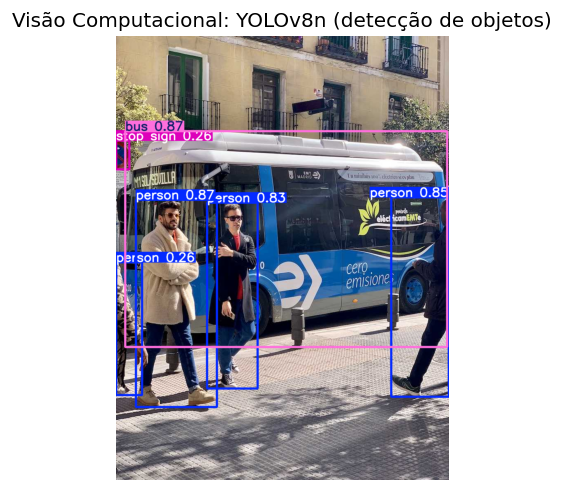

Classe: bus, confiança: 0.87
Classe: person, confiança: 0.87
Classe: person, confiança: 0.85
Classe: person, confiança: 0.83
Classe: person, confiança: 0.26
Classe: stop sign, confiança: 0.26


In [ ]:
# YOLOv8: detecção em uma imagem de exemplo
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# Baixa a imagem de teste
!wget -q https://ultralytics.com/images/bus.jpg -O bus.jpg

# Carrega o modelo leve
model = YOLO('yolov8n.pt')  # baixa automaticamente o peso pré-treinado

# Faz a inferência
results = model('bus.jpg')

# Mostra imagem anotada
annot = results[0].plot()        # array BGR
annot_rgb = annot[:, :, ::-1]    # converte p/ RGB p/ matplotlib

plt.imshow(annot_rgb)
plt.axis('off')
plt.title("Visão Computacional: YOLOv8n (detecção de objetos)")
plt.show()

# Opcional: imprimir rótulos e confianças
names = model.names
for c, conf in zip(results[0].boxes.cls.tolist(), results[0].boxes.conf.tolist()):
    print(f"Classe: {names[int(c)]}, confiança: {conf:.2f}")


5) Visualização Computacional (Scientific Visualization)

Ideia da aplicação: gerar um volume 3D sintético e renderizar um isosurface com Marching Cubes, além de fatiamentos ortogonais.
O que você demonstra: técnicas de visualização de dados científicos 3D (não é CG pura — objetivo aqui é entender dados).

Texto (adicione em uma célula de texto):

Visualização é sobre comunicar padrões de dados (científicos, médicos, CFD, etc.).

Explique o que é um isosurface (superfície onde o valor escalar é constante).

Comente trade-offs: resolução, ruído, custo de renderização.

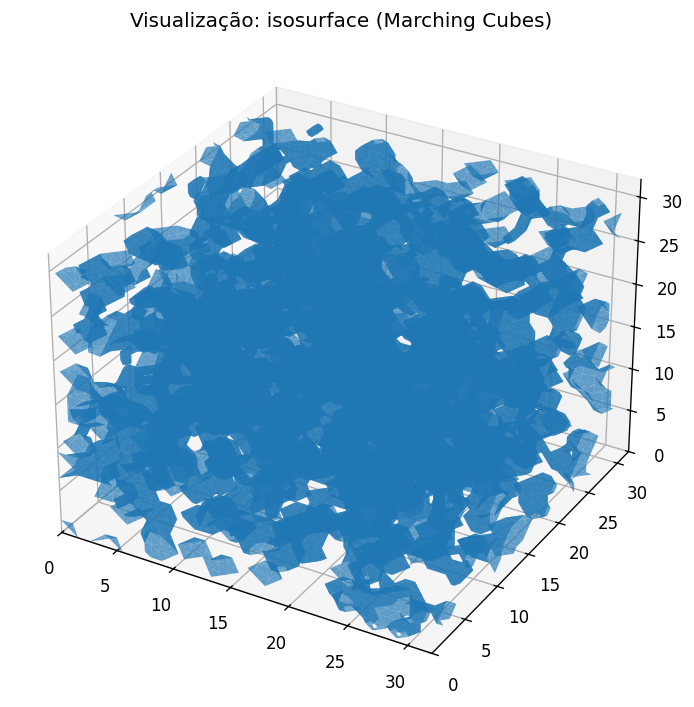

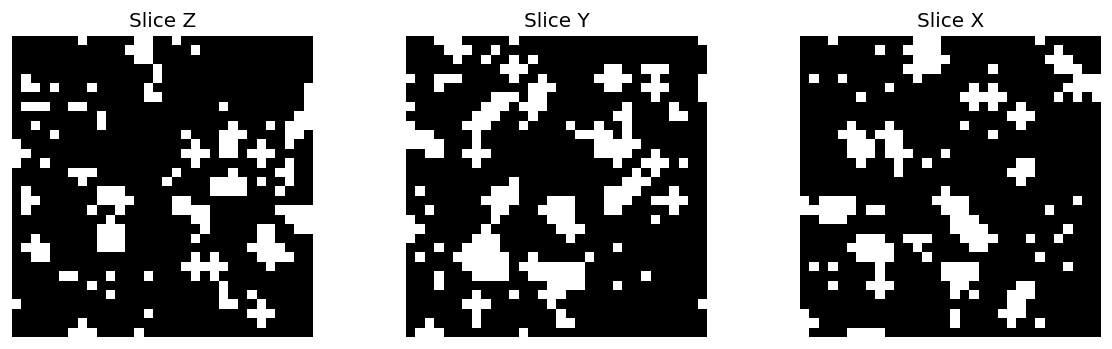

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Fixar semente para reprodutibilidade
np.random.seed(42)

# Volume 3D binário (sintético) — blobs
vol = data.binary_blobs(length=32, n_dim=3, volume_fraction=0.2).astype(np.uint8)

# Isosurface com Marching Cubes
verts, faces, normals, values = measure.marching_cubes(vol, level=0.5)

# Plot 3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.7)
mesh.set_edgecolor('none')
ax.add_collection3d(mesh)

ax.set_xlim(0, vol.shape[0])
ax.set_ylim(0, vol.shape[1])
ax.set_zlim(0, vol.shape[2])
ax.set_title("Visualização: isosurface (Marching Cubes)")
plt.tight_layout()
plt.show()

# Fatiamentos ortogonais (slices)
k = vol.shape[0]//2
fig, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].imshow(vol[k,:,:], cmap='gray'); axs[0].set_title('Slice Z')
axs[1].imshow(vol[:,k,:], cmap='gray'); axs[1].set_title('Slice Y')
axs[2].imshow(vol[:,:,k], cmap='gray'); axs[2].set_title('Slice X')
for a in axs: a.axis('off')
plt.tight_layout(); plt.show()


6) Como escrever o relatório / apresentação

Use uma seção para cada área, sempre com uma figura resultante e comentários curtos:

Síntese de Imagens (CG)

Conceito: gerar imagem a partir de modelos/iluminação.

Aplicação: esfera com shader Blinn-Phong + textura xadrez.

Explique: normais, componente difusa/especular, UV esférico.

Limitações: sem sombras globais/reflexões.

Processamento de Imagens

Conceito: transformar imagem existente.

Aplicação: CLAHE, Sobel, Otsu + opening em coins().

Explique: por que CLAHE; o que bordas mostram; por que morfologia.

Visão Computacional

Conceito: alto nível semântico (detectar/rotular).

Aplicação: YOLOv8n em bus.jpg.

Explique: bounding boxes, classes, confiança, falsos positivos/negativos.

Visualização Computacional

Conceito: comunicar dados científicos.

Aplicação: isosurface (Marching Cubes) + slices de volume 3D.

Explique: o que é um isovalor, quando usar isosurface vs. volume rendering.

Feche com um quadro comparativo (pode ser uma tabela simples) destacando entrada/saída de cada área e objetivo (gerar imagem, transformar imagem, entender conteúdo, visualizar dados).